### Team Info
- Title: F1 Analysis
- Project Name: Accelerated Analytics
- Name: Abhilash Chauhan (abhi19)
- Lead: Abhilash Chauhan

### Team Agreement
- Although code will be written by individuals, all team members should be involved with the technical aspects of the project. All code should be documented well.

- Final decisions will be discussed among all members; fair compromises should be made when necessary.

- Work hours should be split as evenly as possible (actual task output may differ based on an individual's ability / previous experience). This ensures not only fairness but also learning opportunities for everyone. We will keep each other accountable so that one person does not work too much / too little.

- We will use a Git workflow to aid our progress as a team and help us split up the work of coding. Our code will be stored in a shared repository on GitHub.

- Work will not necessarily be done together in person, but good communication via text/call is expected in a timely manner.

### Project Introduction
#### Description
We will use various F1 metrics, including telemetry, weather, and tyre data, to analyze driver and car performance throughout the season and over the years.

#### Research Questions
- Does the driver or car have more effect on race and championship position?
- How is car/driver performance affected by circumstantial factors? (weather, tyres, practice timings, circuit geography, previous race results, speed, driver measurements/experience, team funding, race laps, pit performance, time of day, type of circuit, etc) 
- Is it more important to be faster in corners or in straights?
- How much effect does cornering speed and time spent in corners affect lap time?

#### Data Source(s)
We will be using a prebuilt F1 data library called Fast F1: https://theoehrly.github.io/Fast-F1/.
This library includes F1 data updated to one year ago (2021), that being lap timing, car telemetry and position, tyre data, weather data, the event schedule and session results. If necessary, we will get geographical/geospatial circuit data from Open Elevation: https://open-elevation.com/.

In [30]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [31]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache('./') 

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

In [32]:
# Load the session data
race = ff1.get_session(2021, 'Monza', 'R')

# Get the laps
laps = race.load_laps(with_telemetry=True)

# Get laps of the drivers (BOT and HAM)
laps_ric = laps.pick_driver('RIC')
laps_ver = laps.pick_driver('VER')

# We are only analyzing stint 1, so select that one
laps_ric = laps_ric.loc[laps_ric['Stint'] == 1]
laps_ver = laps_ver.loc[laps_ver['Stint'] == 1]

laps_ric['RaceLapNumber'] = laps_ric['LapNumber'] - 1
laps_ver['RaceLapNumber'] = laps_ver['LapNumber'] - 1

core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']


In [33]:
full_distance_ver_ric = pd.DataFrame()
summarized_distance_ver_ric = pd.DataFrame()

for lap in laps_ver.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    
    # Only run this loop when driver ahead is RIC, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "3"]
    
    if len(telemetry) != 0:
        # Full distance
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1

        full_distance_ver_ric = full_distance_ver_ric.append(lap_telemetry)

        # Average / median distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])

        summarized_distance_ver_ric = summarized_distance_ver_ric.append({
            'Lap': lap[0] + 1,
            'Mean': distance_mean,
            'Median': distance_median
        }, ignore_index = True)

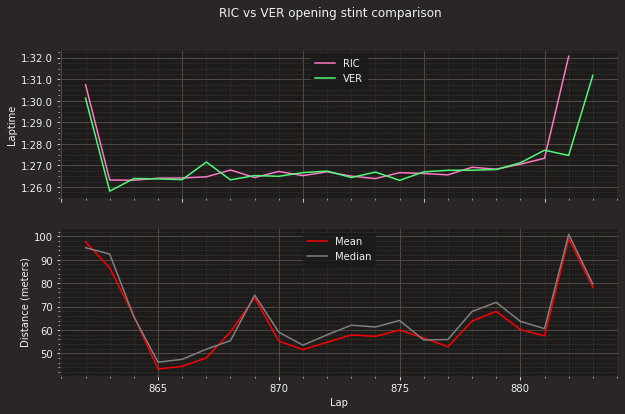

In [34]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots(2)
fig.suptitle("RIC vs VER opening stint comparison")

ax[0].plot(laps_ric['RaceLapNumber'], laps_ric['LapTime'], label='RIC')
ax[0].plot(laps_ver['RaceLapNumber'], laps_ver['LapTime'], label='VER')
ax[0].set(ylabel='Laptime', xlabel='Lap')
ax[0].legend(loc="upper center")

ax[1].plot(summarized_distance_ver_ric['Lap'], summarized_distance_ver_ric['Mean'], label='Mean', color='red')
ax[1].plot(summarized_distance_ver_ric['Lap'], summarized_distance_ver_ric['Median'], label='Median', color='grey')
ax[1].set(ylabel='Distance (meters)', xlabel='Lap')
ax[1].legend(loc="upper center")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()

In [35]:
# Get lap data
lap_telemetry_ric = laps_ric.loc[laps_ric['RaceLapNumber']==4].get_car_data().add_distance()
lap_telemetry_ver = laps_ver.loc[laps_ver['RaceLapNumber']==4].get_car_data().add_distance()

distance_lap3 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==3]
distance_lap4 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==4]
distance_lap5 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==5]
distance_lap6 = full_distance_ver_ric.loc[full_distance_ver_ric['Lap']==6]

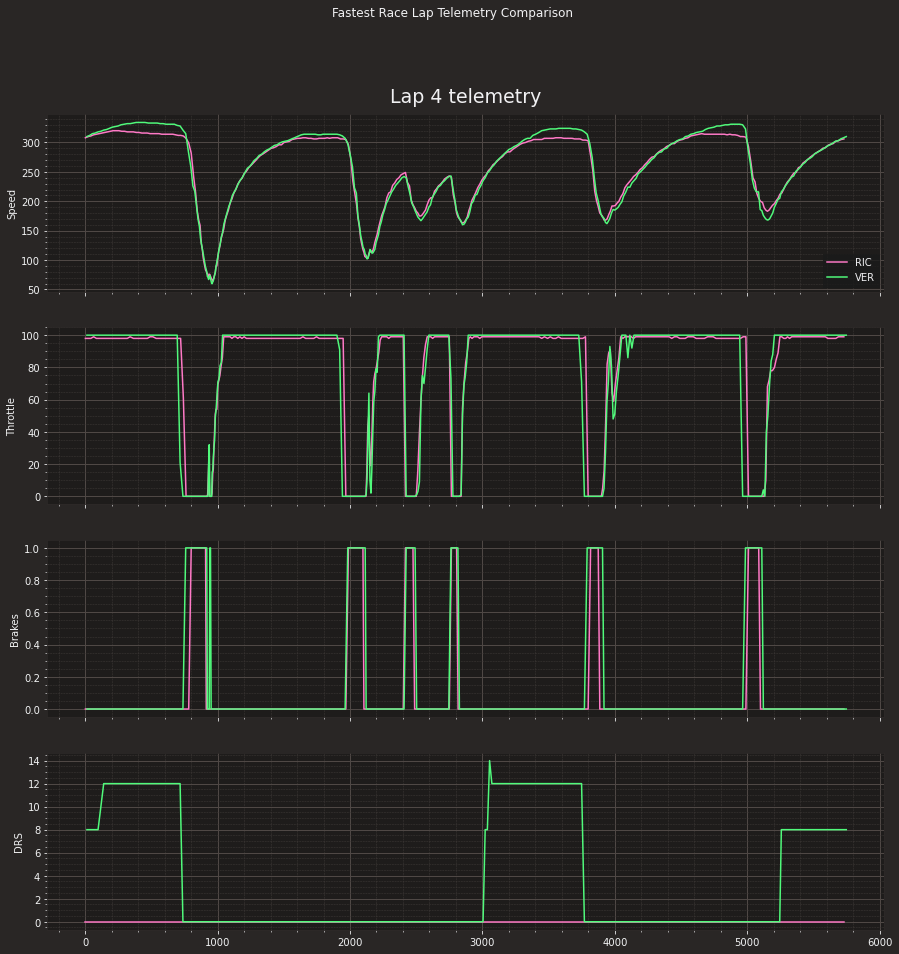

In [36]:
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [15, 15]

fig, ax = plt.subplots(4)
fig.suptitle("Fastest Race Lap Telemetry Comparison")

ax[0].title.set_text("Lap 4 telemetry")
ax[0].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['Speed'], label='RIC')
ax[0].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['Speed'], label='VER')
ax[0].set(ylabel='Speed')
ax[0].legend(loc="lower right")

ax[1].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['Throttle'], label='RIC')
ax[1].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['Throttle'], label='VER')
ax[1].set(ylabel='Throttle')

ax[2].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['Brake'], label='RIC')
ax[2].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['Brake'], label='VER')
ax[2].set(ylabel='Brakes')

ax[3].plot(lap_telemetry_ric['Distance'], lap_telemetry_ric['DRS'], label='RIC')
ax[3].plot(lap_telemetry_ver['Distance'], lap_telemetry_ver['DRS'], label='VER')
ax[3].set(ylabel='DRS')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()

### Analysis
The first subplot shows us the distance between the drivers during lap 3–6, with the main focus on lap 4 where Verstappen was closest. Then, we show all the telemetry of lap 4, where we can see what actually causes the distance between Verstappen and Ricciardo to increase and decrease.

So, now things are becoming intresting. First of all, we can see in the first subplot that Verstappen was really close for a few laps, and actually very close to overtaking Ricciardo into T1 and T3. If you look at the distance during lap 3 compared to the distance during lap 4, you can see that Verstappen actually left much more room between Ricciardo in for example T2 (Curva Grande). This shows that Verstappen was really pushing during lap 4, 5 and 6.

When analyzing the telemetry of lap 4, we can see a few interesting things happen. All of the circles indicate that verstappen was really struggling in the Ricciardo’s dirty air, forcing him to make corrections. For example, when exiting T1, verstappen had to correct his throttle appliance and apply the brakes for a brief moment, probably leaving a few tenths on the table. Also, during the end of the lap, Verstappen had to break earlier than Ricciardo, while he also had to brake for a longer period of time than Ricciardo. It is also really visible from the throttle input that Verstappen really struggled when going through the high-speed corner Ascari.

So based on this, we can try and speculate to say that factors such as "a lack of pressure" from not being a championship front leader helped Ricciardo win.

Let's try to anlyze speeds of the F1 cars through corners next

In [2]:
import numpy as np
import pandas as pd

import fastf1 as ff1
from fastf1 import plotting

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


# Enable the cache
ff1.Cache.enable_cache('cache') 

In [5]:

# Load the session data
quali = ff1.get_session(2022, 'British GP', 'Q')

# Get the laps
laps = quali.load_laps(with_telemetry=True)

# Setting parameters
driver_1, driver_2 = 'HAM', 'RUS'

distance_min, distance_max = 4800, 5500 

# Extracting the laps
laps_driver_1 = laps.pick_driver(driver_1)
laps_driver_2 = laps.pick_driver(driver_2)

telemetry_driver_1 = laps_driver_1.pick_fastest().get_car_data().add_distance()
telemetry_driver_2 = laps_driver_2.pick_fastest().get_car_data().add_distance()

# Identifying the team for coloring later on
team_driver_1 = laps_driver_1.reset_index().loc[0, 'Team']
team_driver_2 = laps_driver_2.reset_index().loc[0, 'Team']

# Assigning labels to what the drivers are currently doing 
telemetry_driver_1.loc[telemetry_driver_1['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_1.loc[telemetry_driver_1['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_1.loc[(telemetry_driver_1['Brake'] == 0) & (telemetry_driver_1['Throttle'] < 100), 'CurrentAction'] = 'Cornering'

telemetry_driver_2.loc[telemetry_driver_2['Brake'] > 0, 'CurrentAction'] = 'Brake'
telemetry_driver_2.loc[telemetry_driver_2['Throttle'] == 100, 'CurrentAction'] = 'Full Throttle'
telemetry_driver_2.loc[(telemetry_driver_2['Brake'] == 0) & (telemetry_driver_2['Throttle'] < 100), 'CurrentAction'] = 'Cornering'


D:\Anaconda\lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for British Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '11', '44', '4', '14', '63', '24', '6', '1

C:\Users\abhi2\AppData\Local\Temp\ipykernel_21940\1630326805.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_actions = actions_driver_1.append(actions_driver_2)


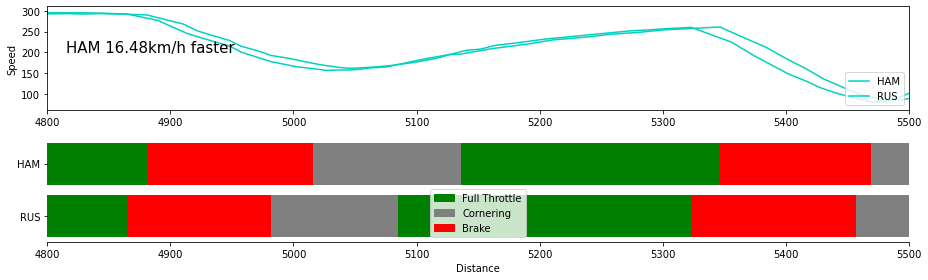

In [6]:
# Numbering each unique action to identify changes, so that we can group later on
telemetry_driver_1['ActionID'] = (telemetry_driver_1['CurrentAction'] != telemetry_driver_1['CurrentAction'].shift(1)).cumsum()
telemetry_driver_2['ActionID'] = (telemetry_driver_2['CurrentAction'] != telemetry_driver_2['CurrentAction'].shift(1)).cumsum()
# Identifying all unique actions
actions_driver_1 = telemetry_driver_1[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()
actions_driver_2 = telemetry_driver_2[['ActionID', 'CurrentAction', 'Distance']].groupby(['ActionID', 'CurrentAction']).max('Distance').reset_index()

actions_driver_1['Driver'] = driver_1
actions_driver_2['Driver'] = driver_2

# Calculating the distance between each action, so that we know how long the bar should be
actions_driver_1['DistanceDelta'] = actions_driver_1['Distance'] - actions_driver_1['Distance'].shift(1)
actions_driver_1.loc[0, 'DistanceDelta'] = actions_driver_1.loc[0, 'Distance']

actions_driver_2['DistanceDelta'] = actions_driver_2['Distance'] - actions_driver_2['Distance'].shift(1)
actions_driver_2.loc[0, 'DistanceDelta'] = actions_driver_2.loc[0, 'Distance']

# Merging together
all_actions = actions_driver_1.append(actions_driver_2)

# Calculating average speed
avg_speed_driver_1 = np.mean(telemetry_driver_1['Speed'].loc[
    (telemetry_driver_1['Distance'] >= distance_min) & 
        (telemetry_driver_1['Distance'] <= distance_max) 
])


avg_speed_driver_2 = np.mean(telemetry_driver_2['Speed'].loc[
    (telemetry_driver_2['Distance'] >= distance_min) & 
        (telemetry_driver_2['Distance'] <= distance_max) 
])

if avg_speed_driver_1 > avg_speed_driver_2:    
    speed_text = f"{driver_1} {round(avg_speed_driver_1 - avg_speed_driver_2,2)}km/h faster"
else:
    speed_text = f"{driver_2} {round(avg_speed_driver_2 - avg_speed_driver_1,2)}km/h faster"

##############################
#
# Setting everything up
#
##############################
plt.rcParams["figure.figsize"] = [13, 4]
plt.rcParams["figure.autolayout"] = True

telemetry_colors = {
    'Full Throttle': 'green',
    'Cornering': 'grey',
    'Brake': 'red',
}

fig, ax = plt.subplots(2)


##############################
#
# Lineplot for speed 
#
##############################
ax[0].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Speed'], label=driver_1, color=ff1.plotting.team_color(team_driver_1))
ax[0].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Speed'], label=driver_2, color=ff1.plotting.team_color(team_driver_2))

# Speed difference
ax[0].text(distance_min + 15,200, speed_text, fontsize = 15)

ax[0].set(ylabel='Speed')
ax[0].legend(loc="lower right")


##############################
#
# Horizontal barplot for telemetry
#
##############################
for driver in [driver_1, driver_2]:
    driver_actions = all_actions.loc[all_actions['Driver'] == driver]
    
    previous_action_end = 0
    for _, action in driver_actions.iterrows():
        ax[1].barh(
            [driver], 
            action['DistanceDelta'], 
            left=previous_action_end, 
            color=telemetry_colors[action['CurrentAction']]
        )
        
        previous_action_end = previous_action_end + action['DistanceDelta']
        
        
##############################
#
# Styling of the plot
#
##############################   
# Set x-label
plt.xlabel('Distance')

# Invert y-axis 
plt.gca().invert_yaxis()

# Remove frame from plot
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# Add legend
labels = list(telemetry_colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=telemetry_colors[label]) for label in labels]
ax[1].legend(handles, labels)

# Zoom in on the specific part we want to see
ax[0].set_xlim(distance_min, distance_max)
ax[1].set_xlim(distance_min, distance_max)

# Save the plot
plt.savefig('2021_Silverstone_Q_HAM_vs_VER_Corner_Analysis.png', dpi=300)

Apparantly, even though Hamilton spends much more time on full throttle, Russell manages to get through this corner sequence a bit faster. There are so many different possible reasons for this: you can think of different downforce levels, different tyre temps after Maggots, Bekcetts and Chapel, et cetera.

### Results
From the analysis done above, we found that pressue from being a true championship contendor can truly affect one's qualifying and race performance which can lead to wins being given up to ensure a solid result to boost one's championship hopes. We also found that in qualifying, cornering speeds and time spent in corners are severely affected by the driver's choice for wing levels and other driver options such as electric deployment during the lap. This can change from race to race since no two tracks are alike. We can pursue further questions such as "what is the best setup for X track?" or "what is the ideal finishing position for someone in the championship race"